In [1]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

In [3]:
cuda = False
w = "../weights/yolov7-tiny33.onnx"
img = cv2.imread("../inference/images/face_detection_sample.jpg")

In [4]:
providers = (
    ["CUDAExecutionProvider", "CPUExecutionProvider"]
    if cuda
    else ["CPUExecutionProvider"]
)
session = ort.InferenceSession(w, providers=providers)

In [19]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White
LEFT_COLOR = (255, 0, 0)
CENTER_COLOR = (0, 255, 0)
RIGHT_COLOR = (0, 0, 255)


def clip(x, y, width, height, normalized=False):
    if normalized:
        x = x * width
        y = y * height
    x = max(x, 0)
    y = max(y, 0)
    x = min(x, width)
    y = min(y, height)
    x = int(round(x))
    y = int(round(y))
    return x, y


def visualize_bbox(
    img,
    bbox,
    landmark,
    landmark_mask,
    color=BOX_COLOR,
    thickness=2,
    radius=2,
    bbox_type="coco",
    landmark_normalized: bool = True,
):
    r"""Visualizes a single bounding box on the image
    Args:
        bbox: coco
    """

    if bbox_type == "coco":
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = (
            int(x_min),
            int(x_min + w),
            int(y_min),
            int(y_min + h),
        )
    elif bbox_type == "pascal_voc":
        x_min, y_min, x_max, y_max = bbox
    elif bbox_type == "albumentations":
        x_min, y_min, x_max, y_max = bbox
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    elif bbox_type == "yolo":
        cx, cy, w, h = bbox
        x_min, y_min, x_max, y_max = cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    else:
        raise KeyError("bbox_type error")

    x_min, y_min, x_max, y_max = (
        int(round(x_min)),
        int(round(y_min)),
        int(round(x_max)),
        int(round(y_max)),
    )

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    if landmark is not None and landmark_mask is not None:
        if landmark_mask[0] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[0],
                    landmark[1],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[1] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[2],
                    landmark[3],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )
        if landmark_mask[2] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[4],
                    landmark[5],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=CENTER_COLOR,
                thickness=-1,
            )
        if landmark_mask[3] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[6],
                    landmark[7],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=LEFT_COLOR,
                thickness=-1,
            )
        if landmark_mask[4] > 0:
            img = cv2.circle(
                img,
                clip(
                    landmark[8],
                    landmark[9],
                    img.shape[1],
                    img.shape[0],
                    landmark_normalized,
                ),
                radius=radius,
                color=RIGHT_COLOR,
                thickness=-1,
            )

    return img


def visualize(
    image,
    bboxes,
    landmarks,
    landmarks_mask,
    bbox_type="coco",
    thickness=2,
    radius=2,
    landmark_normalized: bool = True,
):
    img = image.copy()
    for bbox, landmark, landmark_mask in zip(bboxes, landmarks, landmarks_mask):
        img = visualize_bbox(
            img,
            bbox,
            landmark,
            landmark_mask,
            bbox_type=bbox_type,
            thickness=thickness,
            radius=radius,
            landmark_normalized=landmark_normalized,
        )
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    plt.show()

In [5]:
def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [6]:
names = [
    "face"
]

In [7]:
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

(1, 3, 640, 640)

In [9]:
outname = [i.name for i in session.get_outputs()]
print(outname)

inname = [i.name for i in session.get_inputs()]
print(inname)

['output']
['images']


In [10]:
inp = {inname[0]: im}

In [11]:
# ONNX inference
outputs = session.run(outname, inp)[0]
outputs.shape

(8, 17)

In [22]:
b_idxs = outputs[:, 0]
pred_bbox = outputs[:, 1:5]
pred_cls = outputs[:, 5]
pred_conf = outputs[:, 6]
pred_lmks = outputs[:, 7:17]

print(
    pred_bbox.shape,
    pred_conf.shape,
    pred_cls.shape,
    pred_lmks.shape,
)

(8, 4) (8,) (8,) (8, 10)


In [25]:
nimg = im[0].transpose(1, 2, 0) * 255
nimg = nimg.astype(np.uint8)
# nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [26]:
pnimg = nimg.copy()

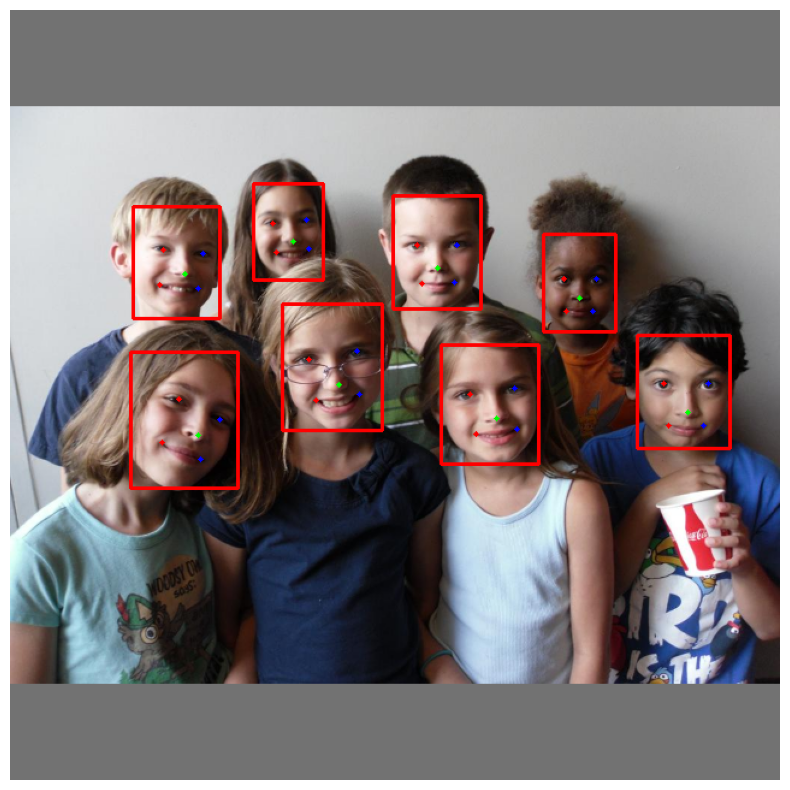

In [27]:
import numpy as np

visualize(
    pnimg,
    pred_bbox.tolist(),
    pred_lmks.tolist(),
    np.ones((pred_bbox.shape[0], 5)),
    bbox_type="pascal_voc",
    landmark_normalized=False,
)